In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from math import sqrt
df = yf.download("BTC-USD", period="5y", interval="1d")
import warnings
warnings.filterwarnings("ignore")

[*********************100%%**********************]  1 of 1 completed


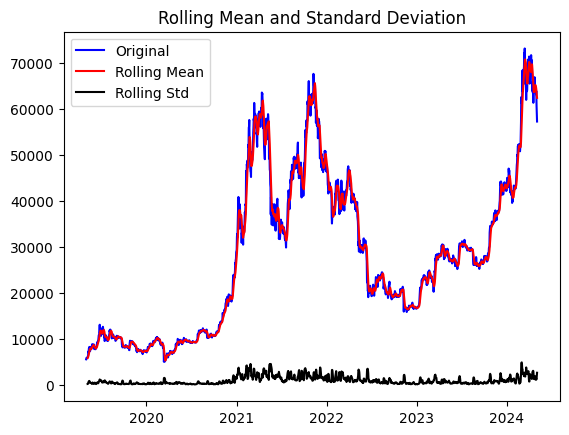

p-value: 0.6056273958764421


In [2]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    adf_test = adfuller(timeseries)
    print(f'p-value: {adf_test[1]}') #not stationary
    
test_stationarity(df["Close"])

<Figure size 640x480 with 0 Axes>

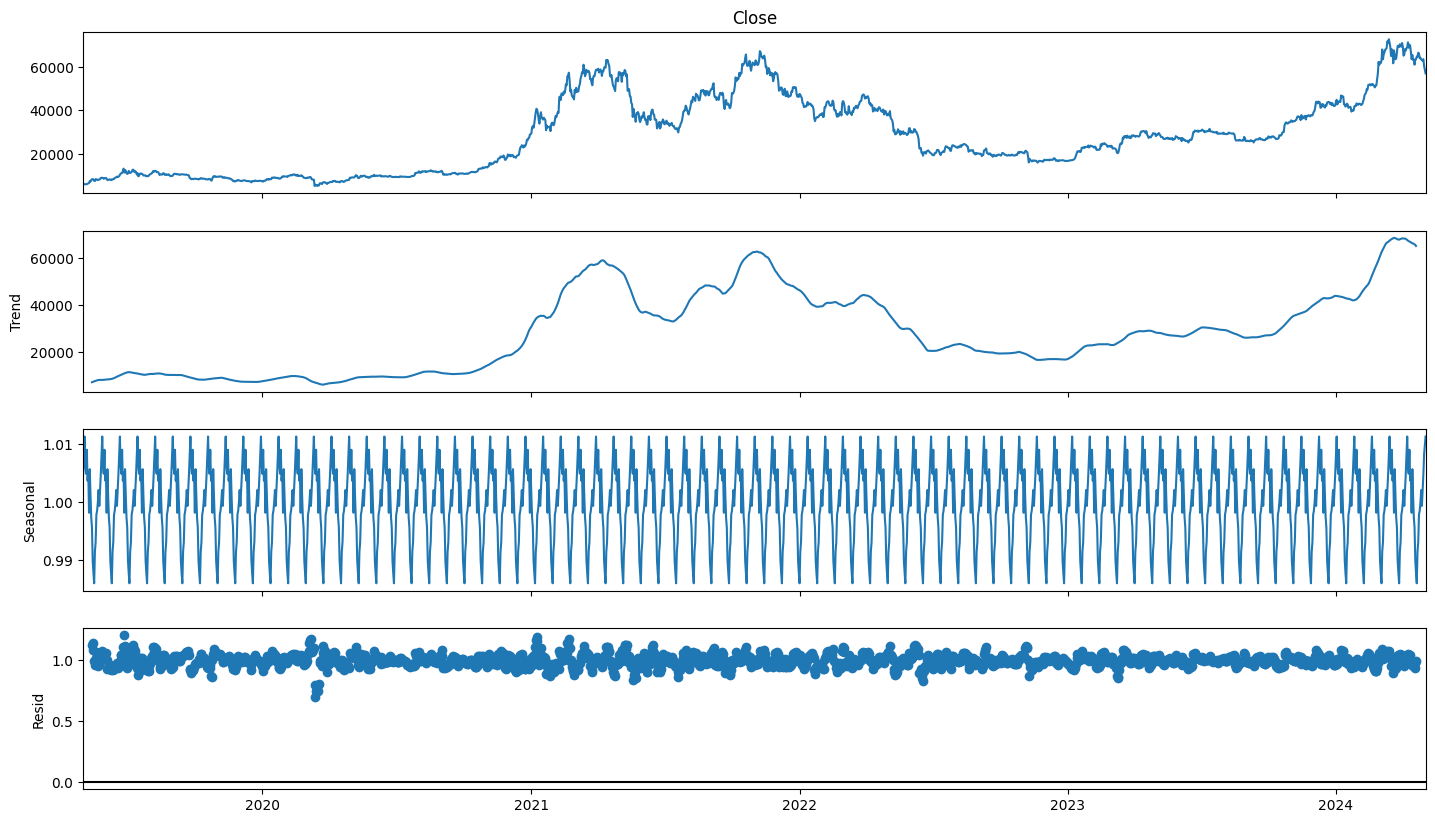

In [3]:
result = seasonal_decompose(df["Close"], model='multiplicative', period =24)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

p-value: 0.0


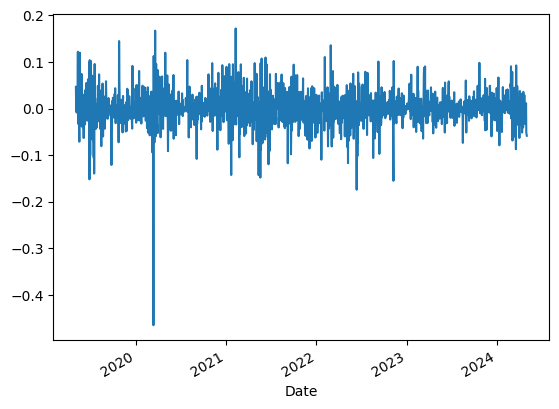

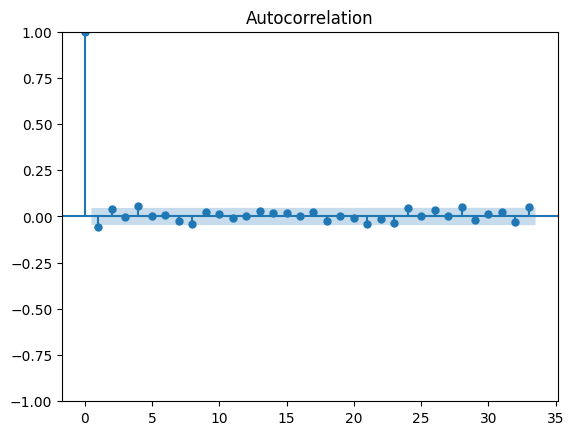

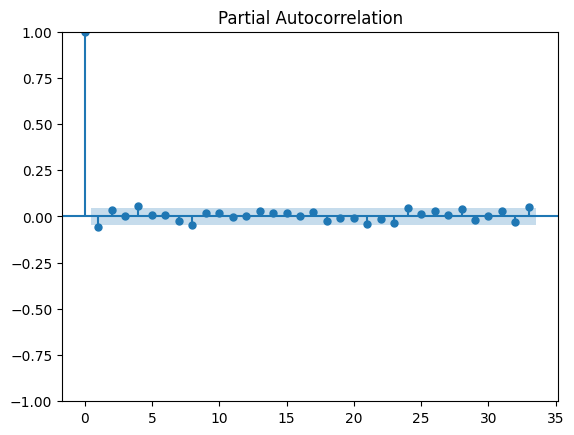

In [4]:
def make_logdiff(df):
    df_logdiff = np.log(df["Close"]) - np.log(df["Close"].shift(1))
    return df_logdiff.dropna()

df["log_diff"] = make_logdiff(df)
df = df.dropna()
df["log_diff"].plot()
acf_original = plot_acf(df["log_diff"])
pacf_original = plot_pacf(df["log_diff"])
adf_test = adfuller(df["log_diff"])
print(f'p-value: {adf_test[1]}') #differenced data is stationary

In [5]:
df_train, df_test = df["Close"][3:int(len(df)*0.9)].dropna(), df["Close"][int(len(df)*0.9):].dropna()

In [6]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['Date'] = pd.to_datetime(working_data['Date'])
working_data = working_data.set_index('Date')

In [7]:

def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 7
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))
#save scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [8]:
X_train.shape[1], X_train.shape[2]

(1, 7)

In [9]:
from keras.optimizers.legacy import Adam
from keras.layers import Dropout

optimizer = Adam(learning_rate=0.0005)

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=500, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=300, verbose=1)])


Epoch 1/500
103/103 [==============================] - 1s 4ms/step - loss: 0.0076 - val_loss: 0.0221
Epoch 2/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 3/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 4/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 6/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 7/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 8/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9/500
103/103 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 10/500
103/103 [==============================] - 0s 3ms/step - loss: 0.0016 - val_lo

In [15]:
import plotly.graph_objs as go
import plotly.offline as py
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [16]:
last_value_transformed = scaler.transform([[working_data.iloc[-1][0]]])  # Ensure it's 2D
# Assuming you have enough previous data points in X_test
new_sequence = X_test[-1, :, :]  # Get the last sequence from X_test

# Slide every value one time step back
new_sequence = np.roll(new_sequence, -1, axis=0)
# Insert the new data point at the end of this sequence
new_sequence[-1, :] = last_value_transformed
# Append this new sequence to X_test
X_test = np.append(X_test, [new_sequence], axis=0)
print("Shape of X_test:", X_test.shape)
# Now you can predict
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))

Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])


Shape of X_test: (178, 1, 7)
6/6 [==============================] - 0s 2ms/step


In [17]:
Test_Dates = df_test.index
trace1 = go.Scatter(
    x = Test_Dates,
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = Test_Dates,
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

ValueError: Found input variables with inconsistent numbers of samples: [176, 177]

In [18]:
#save model
model.save('lstm_model_v2.h5')

In [10]:
import numpy as np
import yfinance as yf
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Assuming the scaler and model are already loaded
scaler = pickle.load(open('scaler.pkl', 'rb'))
model = load_model('lstm_model.h5')

# Download the latest data
df_new = yf.download("BTC-USD", period="3mo", interval="1d")
df_new.dropna(inplace=True)

# Assuming 'look_back' was used during model training
look_back = 7  # Ensure this matches the number of features the model was trained with

# Scale the last 'look_back' closing prices to match the model's training conditions
last_values = df_new['Close'].values[-look_back:]
last_values_scaled = scaler.transform(last_values.reshape(-1, 1))

# Correct reshaping to fit the model's expected input: (samples, time steps, features)
last_values_scaled = last_values_scaled.reshape(1, 1, look_back)

# Predict using the correctly shaped data
predicted_price = model.predict(last_values_scaled)
predicted_price_unscaled = scaler.inverse_transform(predicted_price)  # If you want the price in original scale

print(f"Predicted next price: {predicted_price_unscaled[0][0]}")


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 293ms/step
Predicted next price: 55312.9921875


In [13]:
import plotly.graph_objs as go
import plotly.offline as py
from datetime import timedelta
# Prepare the plot
latest_date = df_new.index.max()
next_date = latest_date + timedelta(days=1)  # assuming daily data, next day prediction

# Historical data trace
trace1 = go.Scatter(
    x = df_new.index,
    y = df_new['Close'],
    mode = 'lines',
    name = 'Historical Prices',
    line = dict(color=('rgb(66, 134, 244)'), width=2)
)

# Predicted price trace
trace2 = go.Scatter(
    x = [next_date],
    y = [predicted_price_unscaled[0][0]],
    mode = 'markers',
    name = 'Predicted Price',
    marker = dict(color=('rgb(244, 146, 65)'), size=10)
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Bitcoin Price Forecast',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price, USD')
)
fig = go.Figure(data=data, layout=layout)

# Display the plot
py.iplot(fig, filename='bitcoin_price_forecast')

In [ ]:
#TODO: 
#1. use log returns instead of close prices
#2. increase lookback window
#3. finetune model
#4. use volume data
#5. cointegration with other assets??
